<a href="https://colab.research.google.com/github/TharinduGee/Carbon_emmision_Prediction_Full_model/blob/main/Carbon_Emission_Predictor_Full_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediction model of the carbon emissions of vehicles by their model data
 
The dataset from the US Environmental Agency is used for this model. (https://www.epa.gov/system/files/documents/2022-04/22-tstcar-2022-04-15.xlsx)


Unfortunately, data is not available at the above link.
So download the dataset from the repo and upload it into the colab notebook.



In [51]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import tensorflow as tf;

In [52]:
#record = pd.read_excel('https://www.epa.gov/system/files/documents/2022-04/22-tstcar-2022-04-15.xlsx');
record = pd.read_excel('/content/21tstcar-2021-03-02.xlsx');


In [53]:
record = record.dropna(thresh = 3000, axis='columns')
record = record.fillna(method= 'ffill',axis='rows')

In [54]:

train_record = record.sample(frac = 0.8, random_state = 3)
test_record = record.drop(train_record.index)


In [55]:
train_target = train_record.pop("CO2 (g/mi)")
test_target = test_record.pop("CO2 (g/mi)")


In [56]:
numeric_feature_names = []
categorical_feature_names = []
for name in train_record.columns:
  if record[name].dtype != object:
    numeric_feature_names.append(name)
  else:
    categorical_feature_names.append(name)


In [57]:

inputs = {}

for name, column in train_record.items():
  if type(column[0]) == str:
    dtype = tf.string
  elif (name in categorical_feature_names):
    dtype = tf.int64
  else:
    dtype = tf.float32


  inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)




In [58]:
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
      values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=-1)


In [59]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(train_record[numeric_feature_names])))

In [60]:
numeric_inputs = {}
preprocessed = []

for name in numeric_feature_names:
  numeric_inputs[name] = inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

preprocessed

[<KerasTensor: shape=(None, 27) dtype=float32 (created by layer 'normalization_2')>]

In [61]:
for name in categorical_feature_names:
  vocab = sorted(set(train_record[name]))
  print(f'name: {name}')
  print(f'vocab: {vocab}\n')

  if type(vocab[0]) is str:
    lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
  else:
    lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

  x = inputs[name][:, tf.newaxis]
  x = lookup(x)
  preprocessed.append(x)

name: Vehicle Manufacturer Name
vocab: ['BMW', 'FCA US LLC', 'FOMOCO', 'Ferrari', 'GM', 'Honda', 'Hyundai', 'Jaguar Land Rover L', 'Karma Automotive, L', 'Kia', 'Lotus', 'MAZDA', 'Maserati', 'Mercedes-Benz', 'Mitsubishi Motors Co', 'Nissan', 'Porsche', 'Rolls-Royce', 'SC Auto Sports, LLC', 'Subaru', 'Tesla', 'Toyota', 'Volkswagen Group of', 'Volvo', 'aston martin']

name: Veh Mfr Code
vocab: ['ASX', 'BMX', 'CRX', 'FEX', 'FJX', 'FMX', 'GMX', 'HNX', 'HYX', 'JLX', 'KAL', 'KMX', 'LTX', 'MAX', 'MBX', 'MTX', 'NSX', 'PRX', 'RRG', 'SCA', 'TKX', 'TSL', 'TYX', 'VGA', 'VVX']

name: Represented Test Veh Make
vocab: ['ACURA', 'AUDI', 'Alfa Romeo', 'Aston Martin', 'BENTLEY', 'BMW', 'BMX', 'BUGATTI', 'BUICK', 'CADILLAC', 'CHEVROLET', 'Chrysler', 'Dodge', 'Ferrari', 'Fiat', 'Ford', 'GMC', 'Genesis', 'HONDA', 'HYUNDAI', 'Honda', 'Hyundai', 'INFINITI', 'Jaguar', 'Jeep', 'KIA', 'Kandi', 'Karma', 'Kia', 'LAMBORGHINI', 'LAND ROVER', 'LEXUS', 'Land Rover', 'Lincoln', 'Lotus', 'MAZDA', 'MINI', 'MITSUBISHI', 

In [62]:
preprocessed

[<KerasTensor: shape=(None, 27) dtype=float32 (created by layer 'normalization_2')>,
 <KerasTensor: shape=(None, 26) dtype=float32 (created by layer 'string_lookup_54')>,
 <KerasTensor: shape=(None, 26) dtype=float32 (created by layer 'string_lookup_55')>,
 <KerasTensor: shape=(None, 54) dtype=float32 (created by layer 'string_lookup_56')>,
 <KerasTensor: shape=(None, 712) dtype=float32 (created by layer 'string_lookup_57')>,
 <KerasTensor: shape=(None, 860) dtype=float32 (created by layer 'string_lookup_58')>,
 <KerasTensor: shape=(None, 483) dtype=float32 (created by layer 'string_lookup_59')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'string_lookup_60')>,
 <KerasTensor: shape=(None, 507) dtype=float32 (created by layer 'string_lookup_61')>,
 <KerasTensor: shape=(None, 9) dtype=float32 (created by layer 'string_lookup_62')>,
 <KerasTensor: shape=(None, 9) dtype=float32 (created by layer 'string_lookup_63')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created 

In [63]:

preprocessed_result = tf.concat(preprocessed,axis=-1)
preprocessed_result

<KerasTensor: shape=(None, 5874) dtype=float32 (created by layer 'tf.concat_2')>

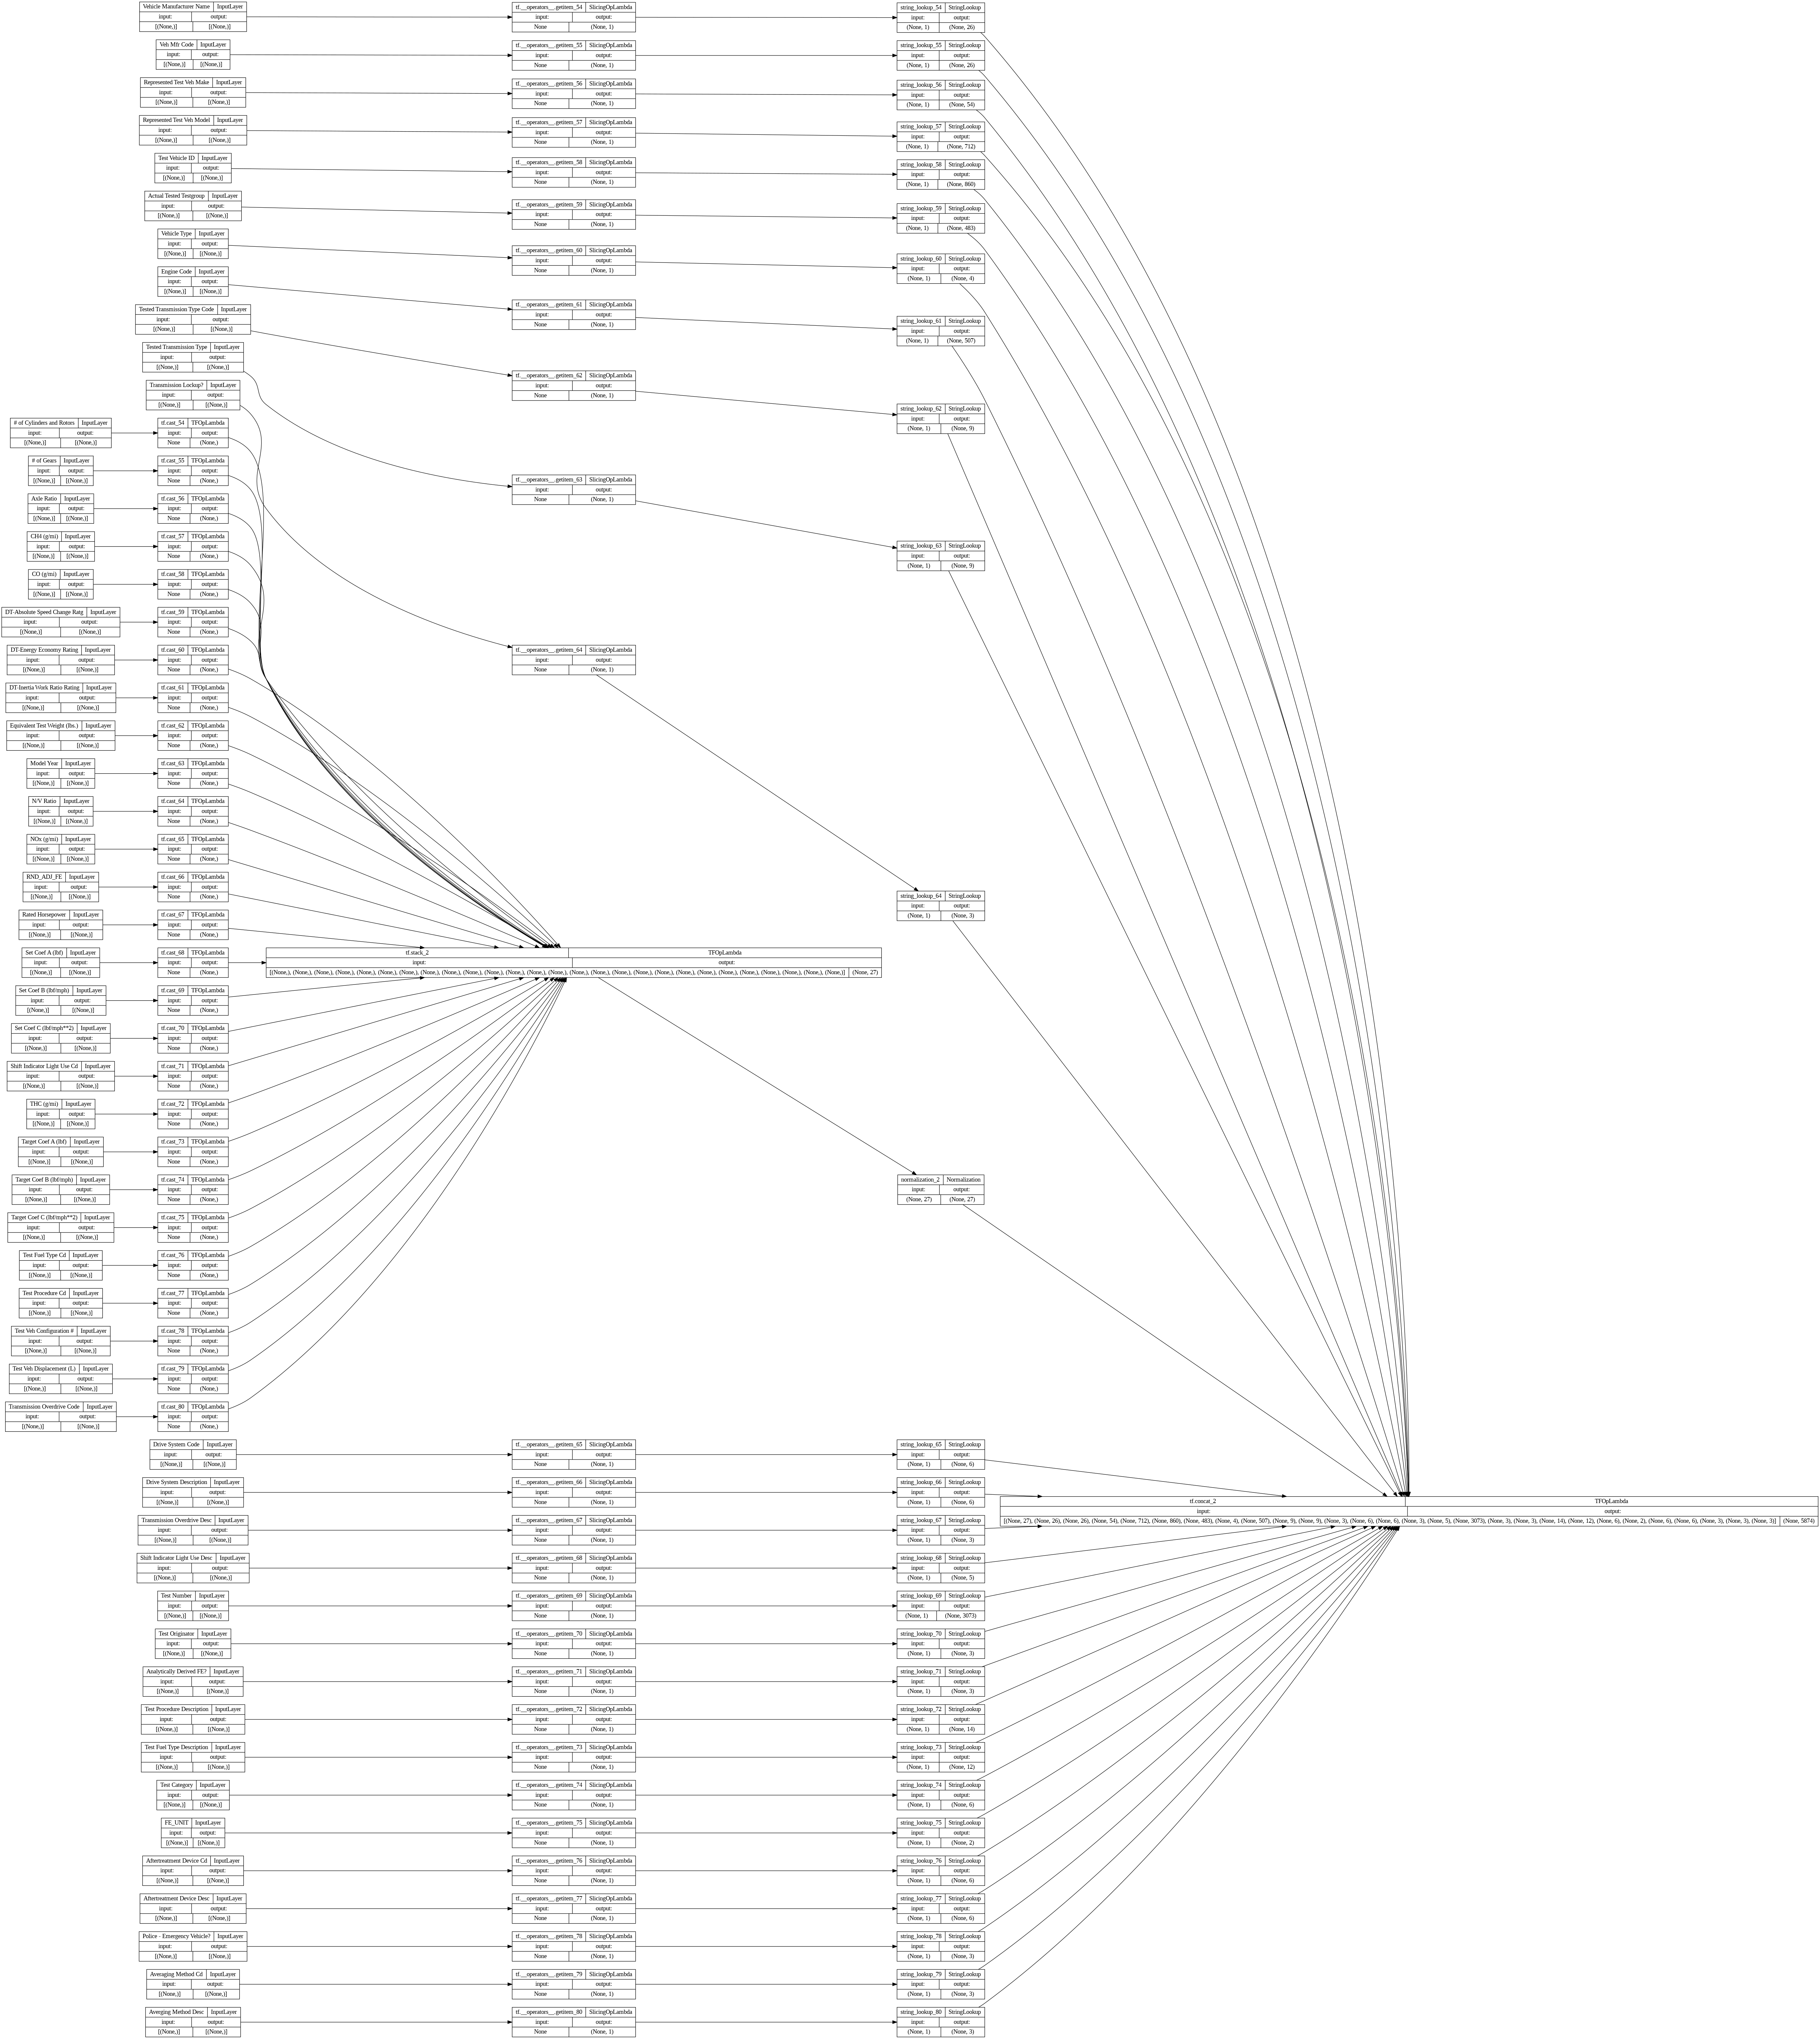

In [64]:
preprocessor = tf.keras.Model(inputs, preprocessed_result)
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

In [65]:
body = tf.keras.Sequential([
  tf.keras.layers.Dense(124, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.005)),
  
  tf.keras.layers.Dense(1)
])


In [66]:
x = preprocessor(inputs)
x

<KerasTensor: shape=(None, 5874) dtype=float32 (created by layer 'model_4')>

In [67]:
result = body(x)
result

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sequential_2')>

In [68]:
model = tf.keras.Model(inputs, result)

model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss = 'mean_absolute_error'
              )

In [69]:
history =  model.fit(dict(train_record), train_target, validation_split = 0.2, verbose=2, epochs=50, batch_size=20)

Epoch 1/50
127/127 - 6s - loss: 144.1219 - val_loss: 33.0858 - 6s/epoch - 48ms/step
Epoch 2/50
127/127 - 2s - loss: 28.9969 - val_loss: 25.1448 - 2s/epoch - 13ms/step
Epoch 3/50
127/127 - 2s - loss: 20.3932 - val_loss: 21.9734 - 2s/epoch - 13ms/step
Epoch 4/50
127/127 - 2s - loss: 17.3206 - val_loss: 19.9282 - 2s/epoch - 12ms/step
Epoch 5/50
127/127 - 2s - loss: 14.3043 - val_loss: 18.7701 - 2s/epoch - 13ms/step
Epoch 6/50
127/127 - 2s - loss: 12.8040 - val_loss: 18.3789 - 2s/epoch - 15ms/step
Epoch 7/50
127/127 - 2s - loss: 11.4286 - val_loss: 18.1115 - 2s/epoch - 18ms/step
Epoch 8/50
127/127 - 2s - loss: 10.5624 - val_loss: 19.4456 - 2s/epoch - 13ms/step
Epoch 9/50
127/127 - 2s - loss: 10.1132 - val_loss: 17.5877 - 2s/epoch - 13ms/step
Epoch 10/50
127/127 - 2s - loss: 9.0930 - val_loss: 17.3471 - 2s/epoch - 13ms/step
Epoch 11/50
127/127 - 2s - loss: 8.3189 - val_loss: 17.1053 - 2s/epoch - 12ms/step
Epoch 12/50
127/127 - 2s - loss: 8.3423 - val_loss: 16.8354 - 2s/epoch - 13ms/step
Epo

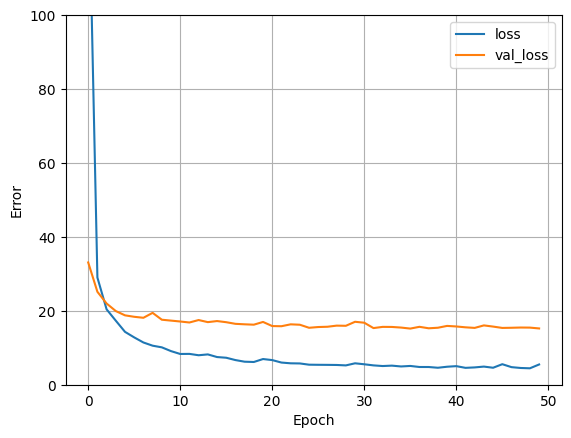

In [74]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [73]:
test_results = {}
test_results['test01'] = model.evaluate(dict(test_record), test_target , verbose='auto')
pd.DataFrame(test_results, index=['Mean absolute error [CO2 (g/mi)]' ]).T

25/25 [==============================] - 0s 15ms/step - loss: 16.2151


,Mean absolute error [CO2 (g/mi)]
test01,16.215055


In [72]:
test_predictions = model.predict(dict(test_record)).flatten()
pd.DataFrame([np.array(test_target),test_predictions,np.array(test_target - test_predictions)],index=['actual','predicted','error']).T

25/25 [==============================] - 1s 12ms/step


,actual,predicted,error
0,306.150000,281.967407,24.182593
1,278.759525,253.406296,25.353230
2,175.495320,169.901871,5.593450
3,182.937761,185.718430,-2.780668
4,329.230000,310.725555,18.504445
...,...,...,...
786,192.000000,236.665985,-44.665985
787,322.000000,293.214996,28.785004
788,212.000000,219.785553,-7.785553
789,207.000000,220.572784,-13.572784
